# Ligand-based Target Prediction Tutorial

### myChEMBL team, ChEMBL Group, EMBL-EBI.

This is a short tutorial on getting target predictions based on the current multi-category Naive Bayesian [ChEMBL_20 models](http://chembl.blogspot.co.uk/2014/04/ligand-based-target-predictions-in.html) for a single molecule input. The predictions are ranked by the output classifier probability or score.

Outline of the tutorial:
* Input a molecule to get target predictions for it
* Assess the predictions
* Retrieve individual feature contributions for a prediction

The two models are under ~/models

First, import IPython helpers:

In [1]:
%pylab inline
from IPython.display import Image

Populating the interactive namespace from numpy and matplotlib


Now, import the necessary modules:

In [2]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw

import pandas as pd
from pandas import concat

from collections import OrderedDict

# By default, the API connects to the main ChEMBL database; set it to use the local version (i.e. myChEMBL) instead...
from chembl_webresource_client.settings import Settings

Settings.Instance().NEW_CLIENT_URL = 'http://localhost/chemblws'

from chembl_webresource_client.new_client import new_client

In [3]:
from sklearn.externals import joblib

In [4]:
rcParams['figure.figsize'] = 10,10

A couple of utility functions:

In [5]:
def calc_scores(classes):
    p = []
    for c in classes:
        p.append(pred_score(c))
    return p

In [6]:
def pred_score(trgt):
    diff = morgan_nb.estimators_[classes.index(trgt)].feature_log_prob_[1] - morgan_nb.estimators_[classes.index(trgt)].feature_log_prob_[0]
    return sum(diff*fp)

Load one of the two models:

In [7]:
morgan_nb = joblib.load('/home/chembl/models_21/10uM/mNB_10uM_all.pkl')

In [8]:
classes = list(morgan_nb.targets)

Check the number of classses/targets:

In [9]:
len(classes)

1429

We have to suppress some warnings because of: https://github.com/python-pillow/Pillow/issues/63

In [10]:
import warnings
warnings.filterwarnings('ignore') 
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Get predictions for a compound

Let's use a molecule (GS-5759) found in [this](http://www.ncbi.nlm.nih.gov/pubmed/24513870) publication. It is a novel compound (not in ChEMBL) reported to have dual activity against PDE4 and beta-2 adrenergic receptor. 

In [11]:
smiles = 'O[C@@H](CNCCCC#CC1=CC=C(C=C1)NC(=O)C=1C=C(C=CC1)S(=O)(=O)C=1C=C2C(=C(C=NC2=C(C1)C)C(=O)N)NC1=CC(=CC=C1)OC)C1=C2C=CC(NC2=C(C=C1)O)=O'

In [12]:
mol = Chem.MolFromSmiles(smiles)

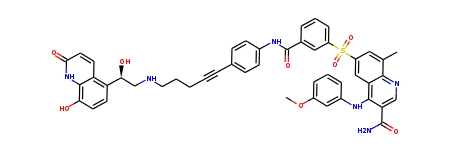

In [13]:
 mol

Convert to the Morgan fingerprint and save the bit dictionary for later...

In [14]:
info={}
fp = Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=2048, bitInfo=info)

Get the predictions in a Pandas frame

In [15]:
predictions = pd.DataFrame(zip(classes, calc_scores(classes),list(morgan_nb.predict_proba(fp)[0])),columns=['id','score','proba'])

In [16]:
predictions.head()

,id,score,proba
0,CHEMBL1075051,-65.891480,7.053404e-33
1,CHEMBL1075104,-30.715833,4.911063e-17
2,CHEMBL1075108,-76.639714,4.848016e-38
3,CHEMBL1075111,-82.024432,2.056597e-40
4,CHEMBL1075115,-12.515053,7.705190e-10


Let's check the distributions of prediction probability and score for the 1244 targets.

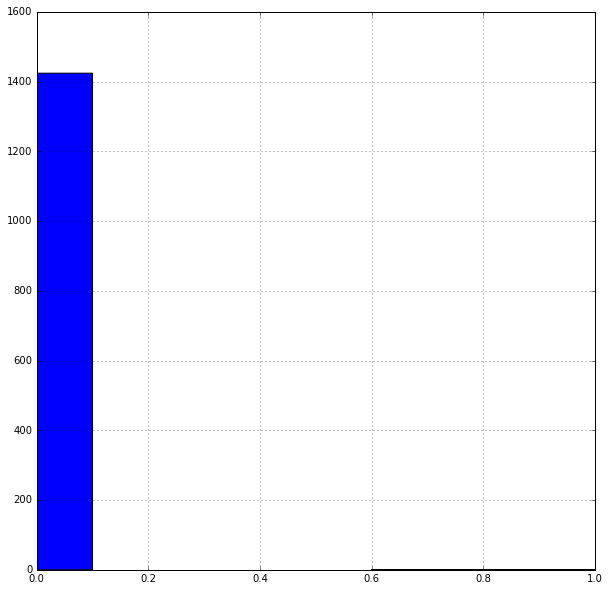

In [17]:
predictions['proba'].hist()

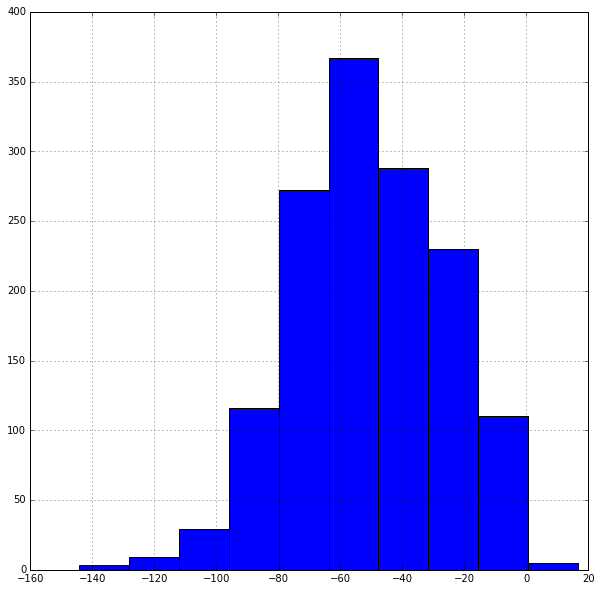

In [18]:
predictions['score'].hist()

Sort by probability and take top 10.

In [19]:
top_preds = predictions.sort(columns=['proba'],ascending=False).head(10)

In [20]:
top_preds

,id,score,proba
1283,CHEMBL5414,16.550049,0.999912
243,CHEMBL210,11.005889,0.994003
652,CHEMBL3252,10.103800,0.836839
249,CHEMBL213,7.094830,0.747240
477,CHEMBL275,6.913094,0.660680
1123,CHEMBL4697,-1.291468,0.000231
851,CHEMBL3864,-1.624611,0.000114
707,CHEMBL3397,-4.884453,0.000102
401,CHEMBL2535,-2.715659,0.000058
710,CHEMBL340,-6.336110,0.000031


Use ChEMBL WS to merge with target information

In [21]:
def fetch_WS(trgt):
    targets = new_client.target
    return targets.get(trgt)

In [22]:
plist = []
for i,e in enumerate(top_preds['id']):
    p = pd.DataFrame(fetch_WS(e), index=(i,))
    plist.append(p)
target_info = concat(plist)

In [23]:
target_info.shape

(10, 6)

In [24]:
target_info

,organism,pref_name,species_group_flag,target_chembl_id,target_components,target_type
0,Cavia porcellus,Beta-2 adrenergic receptor,False,CHEMBL5414,"{u'component_id': 3708, u'accession': u'Q8K4Z4', u'component_type': u'PROTEIN', u'target_component_synonyms': [{u'component_synonym': u'Adrb2', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'Beta-2 adrenergic receptor', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Beta-2 adrenoreceptor', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Beta-2 adrenoceptor', u'syn_type': u'UNIPROT'}]}",SINGLE PROTEIN
1,Homo sapiens,Beta-2 adrenergic receptor,False,CHEMBL210,"{u'component_id': 213, u'accession': u'P07550', u'component_type': u'PROTEIN', u'target_component_synonyms': [{u'component_synonym': u'ADRB2R ', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'B2AR', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'ADRB2', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'Beta-2 adrenergic receptor', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Beta-2 adrenoreceptor', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Beta-2 adrenoceptor', u'syn_type': u'UNIPROT'}]}",SINGLE PROTEIN
2,Rattus norvegicus,Beta-1 adrenergic receptor,False,CHEMBL3252,"{u'component_id': 1573, u'accession': u'P18090', u'component_type': u'PROTEIN', u'target_component_synonyms': [{u'component_synonym': u'Adrb1r', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'Adrb1', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'Beta-1 adrenergic receptor', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Beta-1 adrenoreceptor', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Beta-1 adrenoceptor', u'syn_type': u'UNIPROT'}]}",SINGLE PROTEIN
3,Homo sapiens,Beta-1 adrenergic receptor,False,CHEMBL213,"{u'component_id': 185, u'accession': u'P08588', u'component_type': u'PROTEIN', u'target_component_synonyms': [{u'component_synonym': u'ADRB1R ', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'B1AR', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'ADRB1', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'Beta-1 adrenergic receptor', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Beta-1 adrenoreceptor', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Beta-1 adrenoceptor', u'syn_type': u'UNIPROT'}]}",SINGLE PROTEIN
4,Homo sapiens,Phosphodiesterase 4B,False,CHEMBL275,"{u'component_id': 2177, u'accession': u'Q07343', u'component_type': u'PROTEIN', u'target_component_synonyms': [{u'component_synonym': u'DPDE4', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'PDE4B', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'cAMP-specific 3',5'-cyclic phosphodiesterase 4B', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'DPDE4', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'PDE32', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'3.1.4.53', u'syn_type': u'EC_NUMBER'}]}",SINGLE PROTEIN
5,Plasmodium falciparum,Hexose transporter 1,False,CHEMBL4697,"{u'component_id': 3015, u'accession': u'O97467', u'component_type': u'PROTEIN', u'target_component_synonyms': [{u'component_synonym': u'ht1', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'Hexose transporter 1', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Putative sugar transporter', u'syn_type': u'UNIPROT'}]}",SINGLE PROTEIN
6,Homo sapiens,Protein-tyrosine phosphatase 2C,False,CHEMBL3864,"{u'component_id': 2182, u'accession': u'Q06124', u'component_type': u'PROTEIN', u'target_component_synonyms': [{u'component_synonym': u'PTP2C ', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'SHPTP2', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'PTPN11', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'Tyrosine-protein phosphatase non-receptor type 11', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Protein-tyrosine phosphatase 1D', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Protein-tyrosine phosphatase 2C', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'SH-PTP2', u'sy

Finally, let's get the complete top 10 target predictions in descreasing order of probability.

In [25]:
result = pd.merge(top_preds, target_info, left_on='id', right_on='target_chembl_id')

In [26]:
result

,id,score,proba,organism,pref_name,species_group_flag,target_chembl_id,target_components,target_type
0,CHEMBL5414,16.550049,0.999912,Cavia porcellus,Beta-2 adrenergic receptor,False,CHEMBL5414,"{u'component_id': 3708, u'accession': u'Q8K4Z4', u'component_type': u'PROTEIN', u'target_component_synonyms': [{u'component_synonym': u'Adrb2', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'Beta-2 adrenergic receptor', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Beta-2 adrenoreceptor', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Beta-2 adrenoceptor', u'syn_type': u'UNIPROT'}]}",SINGLE PROTEIN
1,CHEMBL210,11.005889,0.994003,Homo sapiens,Beta-2 adrenergic receptor,False,CHEMBL210,"{u'component_id': 213, u'accession': u'P07550', u'component_type': u'PROTEIN', u'target_component_synonyms': [{u'component_synonym': u'ADRB2R ', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'B2AR', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'ADRB2', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'Beta-2 adrenergic receptor', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Beta-2 adrenoreceptor', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Beta-2 adrenoceptor', u'syn_type': u'UNIPROT'}]}",SINGLE PROTEIN
2,CHEMBL3252,10.103800,0.836839,Rattus norvegicus,Beta-1 adrenergic receptor,False,CHEMBL3252,"{u'component_id': 1573, u'accession': u'P18090', u'component_type': u'PROTEIN', u'target_component_synonyms': [{u'component_synonym': u'Adrb1r', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'Adrb1', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'Beta-1 adrenergic receptor', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Beta-1 adrenoreceptor', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Beta-1 adrenoceptor', u'syn_type': u'UNIPROT'}]}",SINGLE PROTEIN
3,CHEMBL213,7.094830,0.747240,Homo sapiens,Beta-1 adrenergic receptor,False,CHEMBL213,"{u'component_id': 185, u'accession': u'P08588', u'component_type': u'PROTEIN', u'target_component_synonyms': [{u'component_synonym': u'ADRB1R ', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'B1AR', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'ADRB1', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'Beta-1 adrenergic receptor', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Beta-1 adrenoreceptor', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Beta-1 adrenoceptor', u'syn_type': u'UNIPROT'}]}",SINGLE PROTEIN
4,CHEMBL275,6.913094,0.660680,Homo sapiens,Phosphodiesterase 4B,False,CHEMBL275,"{u'component_id': 2177, u'accession': u'Q07343', u'component_type': u'PROTEIN', u'target_component_synonyms': [{u'component_synonym': u'DPDE4', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'PDE4B', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'cAMP-specific 3',5'-cyclic phosphodiesterase 4B', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'DPDE4', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'PDE32', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'3.1.4.53', u'syn_type': u'EC_NUMBER'}]}",SINGLE PROTEIN
5,CHEMBL4697,-1.291468,0.000231,Plasmodium falciparum,Hexose transporter 1,False,CHEMBL4697,"{u'component_id': 3015, u'accession': u'O97467', u'component_type': u'PROTEIN', u'target_component_synonyms': [{u'component_synonym': u'ht1', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'Hexose transporter 1', u'syn_type': u'UNIPROT'}, {u'component_synonym': u'Putative sugar transporter', u'syn_type': u'UNIPROT'}]}",SINGLE PROTEIN
6,CHEMBL3864,-1.624611,0.000114,Homo sapiens,Protein-tyrosine phosphatase 2C,False,CHEMBL3864,"{u'component_id': 2182, u'accession': u'Q06124', u'component_type': u'PROTEIN', u'target_component_synonyms': [{u'component_synonym': u'PTP2C ', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'SHPTP2', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'PTPN11', u'syn_type': u'GENE_SYMBOL'}, {u'component_synonym': u'Tyrosine-protein phosphatase non-receptor type 11', u'syn_type': u'

Not bad! The model retrieved the correct targets in the top 5 predictions out of a pool of 1342 targets.

### Feature contribution

Now let's look at contributions of specific substructural features to the human &beta;2 AR predictions. Which features of the active molecules in the training set were the most important?

In [27]:
bit_scores = (morgan_nb.estimators_[classes.index(result['id'][1])].feature_log_prob_[1] - morgan_nb.estimators_[classes.index(result['id'][1])].feature_log_prob_[0])*fp

The snippet below maps the specific bits back to atomic environments

In [28]:
frags = OrderedDict()
for k in info.keys():
    if bit_scores[k] > 0.1:
        atomId,radius = info[k][0]
        env=Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomId)
        ats = set([atomId])
        for bidx in env:
            bond = mol.GetBondWithIdx(bidx)
            ats.add(bond.GetBeginAtomIdx())
            ats.add(bond.GetEndAtomIdx())
            frag = Chem.MolFragmentToSmiles(mol,atomsToUse=list(ats),bondsToUse=env,rootedAtAtom=atomId)
            legend = str(round(bit_scores[k],2))
            frags[k] = (legend,frag)

In [29]:
legends = [l[1][0] for l in sorted(frags.items(), key=lambda t: t[1][0], reverse=True)][:10]
ffrags = [l[1][1] for l in sorted(frags.items(), key=lambda t: t[1][0], reverse=True)][:10]

In [30]:
fmols=[Chem.MolFromSmarts(s) for s in ffrags]

This was the original molecule

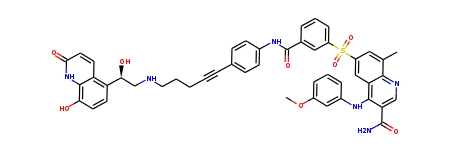

In [31]:
mol

And these are its most important features, based on their enrichent in human &beta;2 AR actives in ChEMBL. The legend is the Bayesian score for each feature. 

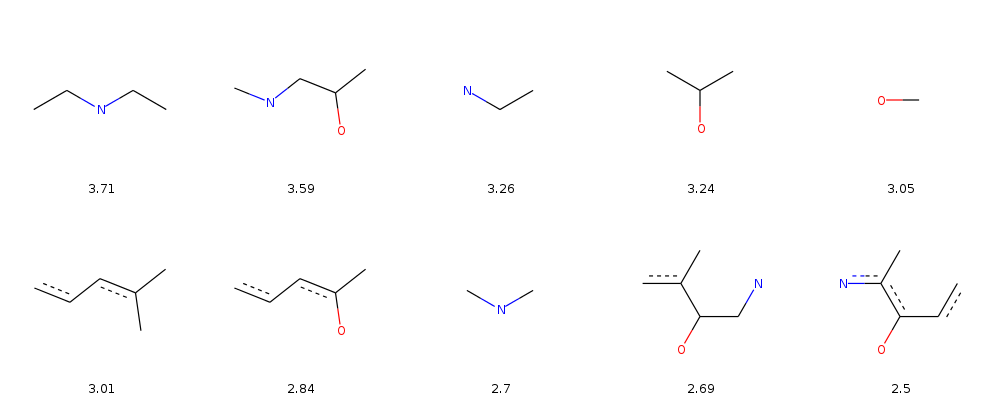

In [33]:
Draw.MolsToGridImage(fmols, molsPerRow=5, legends=legends, useSVG=False)